# Adding Correspondences Using Constraints

In [3]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
# Enable the GPU
autocnet.cuda(enable=True)

from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs
# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## Create the CandidateGraph
Just like the other notebooks this cell creates the candidate graph.  This also patches in functionality to the object on the fly.  To get a handle on what is going on, checkout the [Advanced 1. Extending the CandidateGraph](Advanced 1. Extending the CandidateGraph.ipynb) notebook.

In [4]:
# Create the candidate graph and enable a GPU
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Define a function to do the feature extraction.
def extract_features(self, arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    # Match the interface defined in the edge.
    self.keypoints = kp
    self.descriptors = des
    
    self['downsample_amount'] = downsample_amount

# Import the class and update it.  This updates the current instance of the CandidateGraph
from autocnet.graph.node import Node
Node.extract_features = extract_features

# Extract the features
cg.extract_features(thresh=1)

# Match
cg.match()

# Apply outlier detection - see the above linked notebook if you are curious about what is going on here.
for s,d,e in cg.edges_iter(data=True):
    e.masks['ratio'] = e.matches.ambiguity <= e.matches.ambiguity.quantile(0.015)
    e.masks['score'] = e.matches.score >= e.matches.score.quantile(0.85)
    
# Compute the F Matrix
cg.compute_fundamental_matrices(clean_keys=['ratio', 'score'])

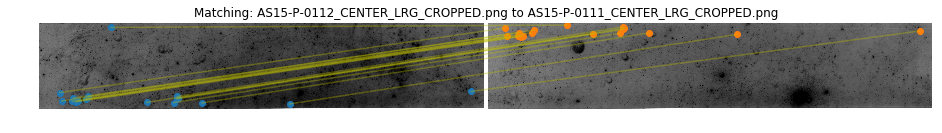

In [5]:
cg.edge[0][1].plot(clean_keys=['fundamental'], line_kwargs={'alpha':0.35}, downsampling=True)

## Fundamental Matrix
Since the fundamental matrix provides the reprojection from a point in one image to an epipolar line in another image, it is possible to utilize a 'good' fundamental matrix to introduce new correspondences into the solution.  We demonstrate this below.

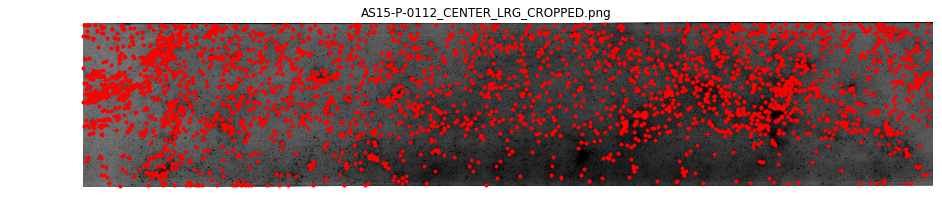

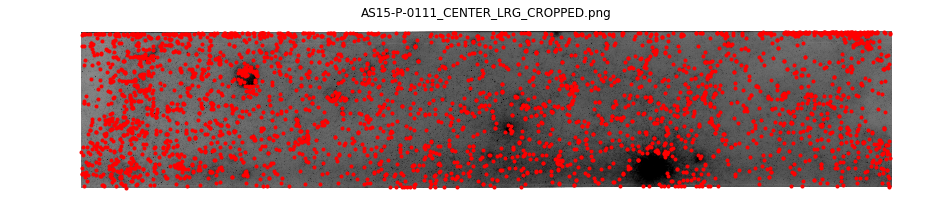

In [6]:
cg.node[0].plot(downsampling=True)
show()
cg.node[1].plot(downsampling=True)

The large black swatch beginning approximately 1/3 of the way from the lower left hand corner of the upper image has correspondences that not being matched into the lower image.  Here, we will try to match some of those.

In [10]:
e = cg.edge[0][1]

kps = cg.node[0].keypoints
search_points = kps.query('x > 3500 and y > 1900')
len(search_points)

107

The first approach is to see which, if any, of the correspondences have been rejected due to the automated application of the ratio and score tests.

In [15]:
candidates = e.matches[e.matches.source_idx.isin(search_points.index)]
candidates[['score', 'ambiguity']].describe()

,score,ambiguity
count,107.000000,107.000000
mean,0.909333,0.977450
std,0.047493,0.028953
min,0.769302,0.865864
25%,0.883995,0.974207
50%,0.913909,0.987876
75%,0.941907,0.995622
max,0.993631,0.999759


In [18]:
good_candidates = candidates.query('ambiguity <= 0.92 and score >= 0.8')
good_candidates

,source_image,source_idx,destination_image,destination_idx,score,ambiguity
1231,0.0,1231,1.0,289,0.985849,0.865864
1240,0.0,1240,1.0,319,0.964188,0.902102
1244,0.0,1244,1.0,298,0.958613,0.906215
1251,0.0,1251,1.0,394,0.984362,0.873866
1277,0.0,1277,1.0,343,0.966390,0.917908
1285,0.0,1285,1.0,341,0.971325,0.918181
1286,0.0,1286,1.0,339,0.913909,0.919853
1299,0.0,1299,1.0,7,0.889101,0.871516


Now use the fundamental matrix to check the reprojective errors of these points.

In [22]:
kp1 = e.source.get_keypoint_coordinates(good_candidates.source_idx)
kp2 = e.destination.get_keypoint_coordinates(good_candidates.destination_idx)

from autocnet.transformation import fundamental_matrix as fm

F = cg.edge[0][1]['fundamental_matrix']
reproj_error = fm.compute_reprojection_error(F, kp1, kp2)
reproj_error

289       0.574755
319       1.291168
298       0.504600
394       7.831943
343       1.133071
341       0.382119
339       2.519372
7      3294.844107
dtype: float64

All but three of the correspondences above look to meet the reprojection error constraint.  This suggests that many more correspondences might have been rejected from our automated methods than needed to be.  It is possible to address this in two ways:

## Option 1:

Add good correspondences in the region to a custom mask.

In [31]:
# Create a new mask
cg.edge[0][1].masks['custom_fundamental'] = cg.edge[0][1].masks['fundamental']

# grab the reprojected coordinates with okay error
reproj = reproj_error[reproj_error < 2]
idx = cg.edge[0][1].matches[cg.edge[0][1].matches.source_idx.isin(reproj.index)]
cg.edge[0][1].masks['custom_fundamental'].iloc[idx.index] = True
idx

,source_image,source_idx,destination_image,destination_idx,score,ambiguity
289,0.0,289,1.0,133,0.921849,0.998795
298,0.0,298,1.0,183,0.855483,0.988294
319,0.0,319,1.0,2804,0.882774,0.960796
341,0.0,341,1.0,3170,0.924507,0.884061
343,0.0,343,1.0,242,0.991612,0.998301


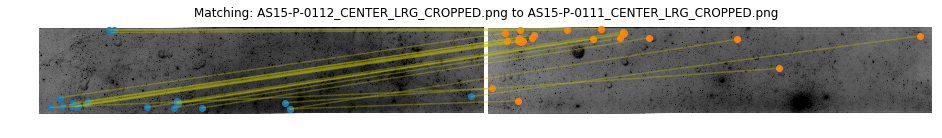

In [32]:
cg.edge[0][1].plot(clean_keys=['custom_fundamental'], downsampling=True, line_kwargs={'alpha':0.35})